In [16]:
import pandas as pd
import math
import numpy as np
import os

import time
from random import sample
from statistics import mean

# import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import scipy

from scipy.stats import skew

In [17]:
#FUNCTION DEFINITIONS
def mean_confidence_interval(data, confidence=0.95):
    '''
    Function to get confidence interval of list of data
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

#Decided against using datetime, so just wrote some custom functions for the int type yyyymm
def monthminus(i):
    '''
    get the previous month
    '''
    if(i == 192606):
        return i
    elif(i%100 == 1):
        year = i//100
        return (year-1)*100 + 12
    else:
        return i-1   


def monthdifference(dob, curr):
    '''
    get difference in months between two dates
    '''
    ydob = dob//100
    ycur = curr//100
    mdob = dob%100
    mcur = curr%100
    return (ycur-ydob)*12 + mcur-mdob


starty = 1926  
startm = 7
endy = 2016
N = 100
startd = starty*100 + startm  
    

In [26]:
#DATA LOADING
data = pd.read_csv('./newdata2.csv') #data only containing relevant share codes
fulldata = pd.read_csv('./fulldata2.csv') #data containing all share codes (to accomodate reclassification)


# Data Cleaning and Preprocessing

Implementing a dataframe matrix, with indices as PERMNO's, and columns as dates to quickly access key stock variables without having to parse through entire database

In [27]:
#DATA PREPROCESSING - limited sharecodes

fulldata = fulldata[~fulldata.SHRCD.isna()]

codereplace = [500,520,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,580,584]
retcodereplace = ['A','S','T','P']
data.loc[data['DLSTCD'].isin(codereplace) & data['DLRET'].isin(retcodereplace), 'DLRET' ] = -0.3
data.loc[data['DLRET'].isin(retcodereplace), 'DLRET'] = -.9999



data['RET'] = data['RET'].fillna(0.00)
data['RETX'] = data['RETX'].fillna(0.00)
data['DLRET'] = data['DLRET'].fillna(0.00)
data.loc[data['RET'].isin(['A','B','C','D','E']), 'RET'] = 0.00
data.loc[data['RETX'].isin(['A','B','C','D','E']), 'RETX'] = 0.00
# data = data.loc[~data['RET'].isin(['B','C'])]
data = data.drop_duplicates(subset=['PERMNO','date','RET'], keep = 'first')


data['date'] = data['date']//100  #only care about monthly returns
# data['date'] = pd.to_datetime(data['date'], format="%Y%m")
# data['date']
    
#ADDING IN DOB
dateofbirths = data.sort_values(by = 'date').drop_duplicates(subset = ['PERMNO'],keep='first')
dateofbirths = dateofbirths.rename(columns={'date':'dateofbirth'})
data = data.merge(dateofbirths[['PERMNO','dateofbirth']], on = 'PERMNO', how = 'left')

#adding in Date of Delisting    
delistings = data.loc[~data['DLSTCD'].isna()]
delistings=  delistings.rename(columns = {'date':'dateofdelisting'})
data = data.merge(delistings[['PERMNO','dateofdelisting']], on = 'PERMNO', how = 'left')


#delete rows  that are useless delisting returns
indexNames = list(data[data['PRC'].isna() & data['SHROUT'].isna() & (data['dateofdelisting']<data['date'])].index)
data.drop(indexNames, inplace = True)


data['Size'] = data['SHROUT'] * abs(data['PRC'])
  
data['Size'].fillna(0, inplace = True)


#get Age by month
data['Age'] = (monthdifference(data['dateofbirth'],data['date'])+1)
#get Size
data['Size'] = data['SHROUT'] * abs(data['PRC'])

data['Size'].fillna(method='ffill', inplace=True)

data['RET'] = data['RET'].apply(pd.to_numeric)
data['RETX'] = data['RETX'].apply(pd.to_numeric)

data['DLRET'] = data['DLRET'].apply(pd.to_numeric)

ret_max1 = data[['date','RET','PERMNO']]

ret_max = ret_max1.pivot(index = 'PERMNO', columns = 'date', values = 'RET')  #matrix of returns



In [28]:
#DATA PREPROCESSING - all sharecodes


listofPERMNO = data.PERMNO.unique()

#filter full data so that only PERMNOs that were at one time 10,11, or 12
fulldata = fulldata.loc[fulldata['PERMNO'].isin(listofPERMNO)]
fulldata['date'] = fulldata['date']//100


fulldata.loc[fulldata['DLSTCD'].isin(codereplace) & fulldata['DLRET'].isin(retcodereplace), 'DLRET' ] = -0.3
fulldata.loc[fulldata['DLRET'].isin(retcodereplace), 'DLRET'] = -.9999
# fulldata.loc[~fulldaDLSTCDta['DLRET'].isna(), 'DLRET'] = -.9999
fulldata['RET'] = fulldata['RET'].fillna(0.00)
fulldata['RETX'] = fulldata['RETX'].fillna(0.00)
fulldata['DLRET'] = fulldata['DLRET'].fillna(0.00)
fulldata.loc[fulldata['RET'].isin(['A','B','C','D','E']), 'RET'] = 0.00
fulldata.loc[fulldata['RETX'].isin(['A','B','C','D','E']), 'RETX'] = 0.00
# fulldata = fulldata.loc[~data['RET'].isin(['B','C'])]
fulldata = fulldata.drop_duplicates(subset=['PERMNO','date','RET'], keep = 'first')


#ADDING IN DOB
dateofbirths = fulldata.sort_values(by = 'date').drop_duplicates(subset = ['PERMNO'],keep='first')
dateofbirths = dateofbirths.rename(columns={'date':'dateofbirth'})
fulldata = fulldata.merge(dateofbirths[['PERMNO','dateofbirth']], on = 'PERMNO', how = 'left')

#adding in Date of Delisting    
delistings = fulldata.loc[~fulldata['DLSTCD'].isna()]
delistings=  delistings.rename(columns = {'date':'dateofdelisting'})
fulldata = fulldata.merge(delistings[['PERMNO','dateofdelisting']], on = 'PERMNO', how = 'left')

#delete useless delisting returns
# print(fulldata['dateofdelisting'])
indexNames = list(fulldata[fulldata['PRC'].isna() & (fulldata['dateofdelisting']<fulldata['date'])].index)
fulldata.drop(indexNames, inplace = True)

#indexNames = list(fulldata[fulldata['PRC'].isna() & fulldata['dateofdelisting'].isna()].index)
indexNames = list(fulldata[fulldata['date']< 192606].index)

fulldata.drop(indexNames, inplace = True)

fulldata['Size'] = data['SHROUT'] * abs(data['PRC'])
    
fulldata['Size'].fillna(0, inplace = True)


fulldata.loc[fulldata.dateofbirth < 192606, 'dateofbirth'] = 192606

fulldata['Age'] = (monthdifference(fulldata['dateofbirth'],fulldata['date'])+1)

fulldata['RET'] = fulldata['RET'].apply(pd.to_numeric)
fulldata['RETX'] = fulldata['RETX'].apply(pd.to_numeric)
fulldata['DLRET'] = fulldata['DLRET'].apply(pd.to_numeric)

ret_max1 = fulldata[['date','RET','PERMNO']]
ret_max2 = fulldata[['date','RETX','PERMNO']]
dlret_max1 = fulldata[['date','DLRET','PERMNO']]
age_max1 = fulldata[['date','Age','PERMNO']]
price_max1 = fulldata[['date', 'PRC','PERMNO']]
# div_max1 = fulldata[['date','DIVAMT','PERMNO']]
size_max1 = fulldata[['date','Size','PERMNO']]

full_ret_max = ret_max1.pivot(index = 'PERMNO', columns = 'date', values = 'RET')
nodiv_full_ret_max = ret_max2.pivot(index = 'PERMNO', columns = 'date', values = 'RETX')
dlret_max = dlret_max1.pivot(index = 'PERMNO', columns = 'date', values = 'DLRET')    
age_max =  age_max1.pivot(index = 'PERMNO', columns = 'date', values = 'Age')
price_max = price_max1.pivot(index = 'PERMNO', columns = 'date', values = 'PRC')
# div_max = div_max1.pivot(index='PERMNO',columns='date',values='DIVAMT')
size_max = size_max1.pivot(index = 'PERMNO', columns = 'date', values = 'Size')

# Creating ListofAvailable Dict

Have a dict of lists of available stocks in each month

In [29]:
month = startm
year=  starty

listofdates = []
listofavailable = {}
listofyears = []
fulllistofavailable = {}
while(year<=endy):
    listofyears.append(year)
    while(month <= 12):
        curdate = year*100 + month
        listofdates.append(curdate)
        y = ret_max.index[(ret_max[curdate].notnull())].tolist()
        x = full_ret_max.index[(full_ret_max[curdate].notnull())].tolist()
        listofavailable[curdate] = y
        fulllistofavailable[curdate] = x
        month += 1
    month = 1
    year += 1

# Rebalanced Portfolio Method Simulation

This portfolio selected N stocks in the starting month such that each stock is of equal weight in the portfolio. After each month the stocks are rebalanced so that the equal weighting is maintained. Delisted stocks are replaced.

In [30]:
simulation_num = 100



#Rebalanced Simulation
ew_ret = {} #dictionary of monthly returns   
exits = []
entrants = []
ret_list = []
# in_list = []
ew_ret_list = {}
year = starty
month = startm
    
    
n_list = [5,25,50,100]
#dictionaries to keep track of variables on a month by month basis
ret_dict = {'rebalanced':{},'bootstrapped':{}}
turnover_dict = {'rebalanced':{},'bootstrapped':{}}
turnover_dict_list = {'rebalanced':{},'bootstrapped':{}}
ret_dict_list = {'rebalanced':{},'bootstrapped':{}}
age_dict_list = {'rebalanced':{},'bootstrapped':{}}
size_dict_list = {'rebalanced':{},'bootstrapped':{}}
for strat in ret_dict:
    for w in n_list:
        ret_dict[strat][w] = []
        turnover_dict[strat][w] = []
        ret_dict_list[strat][w] = {}
        age_dict_list[strat][w] = {}
        size_dict_list[strat][w] = {}
        turnover_dict_list[strat][w] = {}
        for i in listofdates:
            turnover_dict_list[strat][w][i] = []
            ret_dict_list[strat][w][i] = []
            age_dict_list[strat][w][i] = []
            size_dict_list[strat][w][i] = []
            age_dict_list[strat][w][i] = []

strat = 'rebalanced'
for N in n_list:
    for j in range(0,simulation_num):
        ew_ret = {}
        turnover = [] #list to keep track of turnover month by month
#         exits = []
#         entrants = []
#         in_list = []
        total_ret = 1 #initalize return as zero
        total_turn = 0
        start = time.time()
        for i in listofdates:
            if(i == startd):
                prev_sample = sample(listofavailable[i],N) #Take first sample
                ew_ret[i] = sum(ret_max.loc[prev_sample,i])
                ew_ret[i] += sum(dlret_max.loc[prev_sample,i])
                ew_ret[i] = 1 + ew_ret[i] /N #calculate monthly return
                ret_dict_list[strat][N][i].append(ew_ret[i])
                age_dict_list[strat][N][i].append(mean(age_max.loc[prev_sample,i]))
                size_dict_list[strat][N][i].append(mean(size_max.loc[prev_sample,i]))
                turn = np.mean(np.abs(ret_max.loc[prev_sample,i].values))
                turnover_dict_list[strat][N][i].append(turn)
                total_turn += turn
            else:
                    
                cur_sample = list(set(prev_sample)& set(listofavailable[i])) #find items in next date

                diff = list(set(prev_sample) - set(cur_sample)) #find items that have exited either due to reclassification or delisting
                reclassified = list(set(fulllistofavailable[i]) & set(diff)) #find items that have been reclassified

                cur_sample = cur_sample + reclassified #add back in items that have been reclassified
                
                percent_prc_chg = np.abs(nodiv_full_ret_max.loc[cur_sample,i])

                exitnum = N - len(cur_sample) #how many stocks have exited
                turn = (np.mean(percent_prc_chg) * len(cur_sample) + exitnum)/N
                turnover_dict_list[strat][N][i].append(turn)
                total_turn += turn
                filling = sample(set(listofavailable[i])-set(cur_sample), exitnum) #sample in to fill exited stocks

                if(len(filling)>0):  #add new samples to portfolio
                    cur_sample.extend(filling) 
                    
                normal_returns = full_ret_max.loc[cur_sample,i]
                delisting_returns = dlret_max.loc[cur_sample,i]


                ew_ret[i] = sum(normal_returns) #get return matrix
                ew_ret[i] += sum(delisting_returns) #get delisting returns
                ew_ret[i] = 1 + ew_ret[i]/N #return for a given month
                
                ret_dict_list[strat][N][i].append(ew_ret[i]) #append to monthly return list
                
                age_dict_list[strat][N][i].append(mean(age_max.loc[cur_sample,i]))
                size_dict_list[strat][N][i].append(mean(size_max.loc[cur_sample,i]))
                
                prev_sample = cur_sample
            total_ret = total_ret * ew_ret[i] #keep a running track of total return
        end = time.time()
    
        annualizedret = total_ret ** (1/((len(listofdates)-1)/12)) -1
        print(f'It took {round(end-start,2)} seconds for simulation #{j+1} of portfolio size {N}, Ann. Ret. = {annualizedret}')

        ret_dict[strat][N].append(annualizedret)
        total_turnover = total_turn/len(listofdates)
        turnover_dict[strat][N].append(total_turnover)


It took 2.71 seconds for simulation #1 of portfolio size 5, Ann. Ret. = 0.12227078557397486
It took 2.41 seconds for simulation #2 of portfolio size 5, Ann. Ret. = 0.12669549078790943
It took 2.45 seconds for simulation #3 of portfolio size 5, Ann. Ret. = 0.07289604872013178
It took 2.54 seconds for simulation #4 of portfolio size 5, Ann. Ret. = 0.10841136505534577
It took 2.69 seconds for simulation #5 of portfolio size 5, Ann. Ret. = 0.0979478164532912
It took 2.57 seconds for simulation #6 of portfolio size 5, Ann. Ret. = 0.12877357853429983
It took 2.48 seconds for simulation #7 of portfolio size 5, Ann. Ret. = 0.09078897235275218
It took 2.36 seconds for simulation #8 of portfolio size 5, Ann. Ret. = 0.13581622494282186
It took 2.53 seconds for simulation #9 of portfolio size 5, Ann. Ret. = 0.08427779999246399
It took 2.55 seconds for simulation #10 of portfolio size 5, Ann. Ret. = 0.12015785288623282
It took 2.42 seconds for simulation #11 of portfolio size 5, Ann. Ret. = 0.12280

It took 2.36 seconds for simulation #90 of portfolio size 5, Ann. Ret. = 0.08053923466690116
It took 2.43 seconds for simulation #91 of portfolio size 5, Ann. Ret. = 0.10747683192815227
It took 2.54 seconds for simulation #92 of portfolio size 5, Ann. Ret. = 0.11056107964380679
It took 2.42 seconds for simulation #93 of portfolio size 5, Ann. Ret. = 0.12170418057776056
It took 2.47 seconds for simulation #94 of portfolio size 5, Ann. Ret. = 0.11580368968828836
It took 2.53 seconds for simulation #95 of portfolio size 5, Ann. Ret. = 0.09267070492783946
It took 2.54 seconds for simulation #96 of portfolio size 5, Ann. Ret. = 0.10542623535569784
It took 2.35 seconds for simulation #97 of portfolio size 5, Ann. Ret. = 0.12361580588864429
It took 2.35 seconds for simulation #98 of portfolio size 5, Ann. Ret. = 0.12499574157965321
It took 2.37 seconds for simulation #99 of portfolio size 5, Ann. Ret. = 0.09655247288128566
It took 2.51 seconds for simulation #100 of portfolio size 5, Ann. Ret

It took 2.44 seconds for simulation #78 of portfolio size 25, Ann. Ret. = 0.12675711398088607
It took 2.44 seconds for simulation #79 of portfolio size 25, Ann. Ret. = 0.12017487202331778
It took 2.47 seconds for simulation #80 of portfolio size 25, Ann. Ret. = 0.13257363299797942
It took 2.45 seconds for simulation #81 of portfolio size 25, Ann. Ret. = 0.1304975077605024
It took 2.48 seconds for simulation #82 of portfolio size 25, Ann. Ret. = 0.13316079220967691
It took 2.46 seconds for simulation #83 of portfolio size 25, Ann. Ret. = 0.12703882821861967
It took 2.45 seconds for simulation #84 of portfolio size 25, Ann. Ret. = 0.13180013210080022
It took 2.45 seconds for simulation #85 of portfolio size 25, Ann. Ret. = 0.12891045449913618
It took 2.44 seconds for simulation #86 of portfolio size 25, Ann. Ret. = 0.12885701517015846
It took 2.46 seconds for simulation #87 of portfolio size 25, Ann. Ret. = 0.11655527717891845
It took 2.46 seconds for simulation #88 of portfolio size 25,

It took 2.56 seconds for simulation #66 of portfolio size 50, Ann. Ret. = 0.13590002570975046
It took 2.6 seconds for simulation #67 of portfolio size 50, Ann. Ret. = 0.1404285860599901
It took 2.56 seconds for simulation #68 of portfolio size 50, Ann. Ret. = 0.13476911009953207
It took 2.56 seconds for simulation #69 of portfolio size 50, Ann. Ret. = 0.12705924691319037
It took 2.59 seconds for simulation #70 of portfolio size 50, Ann. Ret. = 0.12578303238423838
It took 2.55 seconds for simulation #71 of portfolio size 50, Ann. Ret. = 0.132365280595085
It took 2.54 seconds for simulation #72 of portfolio size 50, Ann. Ret. = 0.1258629962564839
It took 2.63 seconds for simulation #73 of portfolio size 50, Ann. Ret. = 0.12492112226126562
It took 2.6 seconds for simulation #74 of portfolio size 50, Ann. Ret. = 0.1323557290680788
It took 2.62 seconds for simulation #75 of portfolio size 50, Ann. Ret. = 0.12174787795425424
It took 2.63 seconds for simulation #76 of portfolio size 50, Ann. 

It took 2.93 seconds for simulation #54 of portfolio size 100, Ann. Ret. = 0.12793861657738392
It took 2.83 seconds for simulation #55 of portfolio size 100, Ann. Ret. = 0.1343511431018498
It took 2.76 seconds for simulation #56 of portfolio size 100, Ann. Ret. = 0.13160937528913275
It took 2.84 seconds for simulation #57 of portfolio size 100, Ann. Ret. = 0.1288123408317976
It took 2.74 seconds for simulation #58 of portfolio size 100, Ann. Ret. = 0.12900220297868326
It took 2.87 seconds for simulation #59 of portfolio size 100, Ann. Ret. = 0.1267906617478185
It took 2.77 seconds for simulation #60 of portfolio size 100, Ann. Ret. = 0.12834545485698334
It took 2.79 seconds for simulation #61 of portfolio size 100, Ann. Ret. = 0.12988364568567135
It took 2.78 seconds for simulation #62 of portfolio size 100, Ann. Ret. = 0.13205261935306556
It took 2.78 seconds for simulation #63 of portfolio size 100, Ann. Ret. = 0.13028486858022226
It took 2.79 seconds for simulation #64 of portfolio 

# Bootstrapped Portfolio Simulation

This portfolio selects N stocks with equal weight in the first month. It then selects N new stocks every new month. Turnover is obviously very high with this method.

In [36]:
#Bootstrapped Simulation

simulation_num = 100

boot_ret_list = []

strat = 'bootstrapped'

for N in n_list:
    for j in range(0,simulation_num):
        total_ret = 1.00
        start = time.time()
        for i in listofdates:
            prev_sample = sample(listofavailable[i],N)
            ew_ret[i] = sum(ret_max.loc[prev_sample,i])
            ew_ret[i] += sum(dlret_max.loc[prev_sample,i])
            ew_ret[i] = 1 + ew_ret[i] /N
            averageage = mean(age_max.loc[prev_sample,i])
            averagesize = mean(size_max.loc[prev_sample,i])
            age_dict_list[strat][N][i].append(averageage)
            ret_dict_list[strat][N][i].append(ew_ret[i])
            size_dict_list[strat][N][i].append(averagesize)
            turnover_dict_list[strat][N][i].append(1)
            total_ret = total_ret * ew_ret[i]
        end = time.time()
        annualizedret = total_ret ** (1/(len(listofdates)/12)) -1
        ret_dict[strat][N].append(annualizedret)
        print(f'It took {round(end-start,2)} seconds for simulation #{j+1} of portfolio size {N}, Ann. Ret. = {annualizedret}')





It took 1.47 seconds for simulation #1 of portfolio size 5, Ann. Ret. = 0.1418293041381875
It took 1.51 seconds for simulation #2 of portfolio size 5, Ann. Ret. = 0.04346255978837954
It took 1.54 seconds for simulation #3 of portfolio size 5, Ann. Ret. = 0.06652819103725616
It took 1.49 seconds for simulation #4 of portfolio size 5, Ann. Ret. = 0.0775957474430986
It took 1.5 seconds for simulation #5 of portfolio size 5, Ann. Ret. = 0.06144776942489405
It took 1.48 seconds for simulation #6 of portfolio size 5, Ann. Ret. = 0.13419348811435183
It took 1.46 seconds for simulation #7 of portfolio size 5, Ann. Ret. = 0.0581116787276621
It took 1.51 seconds for simulation #8 of portfolio size 5, Ann. Ret. = 0.10892210816375858
It took 1.48 seconds for simulation #9 of portfolio size 5, Ann. Ret. = 0.13802322683587565
It took 1.53 seconds for simulation #10 of portfolio size 5, Ann. Ret. = 0.11747029259142394
It took 1.55 seconds for simulation #11 of portfolio size 5, Ann. Ret. = 0.13017853

It took 1.59 seconds for simulation #92 of portfolio size 5, Ann. Ret. = 0.06545223227741537
It took 1.56 seconds for simulation #93 of portfolio size 5, Ann. Ret. = 0.10650836455687629
It took 1.59 seconds for simulation #94 of portfolio size 5, Ann. Ret. = 0.08581829759803772
It took 1.56 seconds for simulation #95 of portfolio size 5, Ann. Ret. = 0.10281924398671549
It took 1.46 seconds for simulation #96 of portfolio size 5, Ann. Ret. = 0.094363497649256
It took 1.47 seconds for simulation #97 of portfolio size 5, Ann. Ret. = 0.08023177585896524
It took 1.44 seconds for simulation #98 of portfolio size 5, Ann. Ret. = 0.13073220140158504
It took 1.45 seconds for simulation #99 of portfolio size 5, Ann. Ret. = 0.11041685732982054
It took 1.42 seconds for simulation #100 of portfolio size 5, Ann. Ret. = 0.1324883417070497
It took 1.6 seconds for simulation #1 of portfolio size 25, Ann. Ret. = 0.1284684303169521
It took 1.63 seconds for simulation #2 of portfolio size 25, Ann. Ret. = 0

It took 1.51 seconds for simulation #80 of portfolio size 25, Ann. Ret. = 0.12625300084758173
It took 1.5 seconds for simulation #81 of portfolio size 25, Ann. Ret. = 0.0975912486491235
It took 1.49 seconds for simulation #82 of portfolio size 25, Ann. Ret. = 0.10584320736071828
It took 1.48 seconds for simulation #83 of portfolio size 25, Ann. Ret. = 0.10571592904104787
It took 1.48 seconds for simulation #84 of portfolio size 25, Ann. Ret. = 0.11627373499726912
It took 1.49 seconds for simulation #85 of portfolio size 25, Ann. Ret. = 0.10258270866029506
It took 1.49 seconds for simulation #86 of portfolio size 25, Ann. Ret. = 0.11209933412976492
It took 1.5 seconds for simulation #87 of portfolio size 25, Ann. Ret. = 0.11994876756640815
It took 1.5 seconds for simulation #88 of portfolio size 25, Ann. Ret. = 0.10848673392104358
It took 1.49 seconds for simulation #89 of portfolio size 25, Ann. Ret. = 0.12647674601086356
It took 1.49 seconds for simulation #90 of portfolio size 25, An

It took 1.63 seconds for simulation #68 of portfolio size 50, Ann. Ret. = 0.11258487667980943
It took 1.64 seconds for simulation #69 of portfolio size 50, Ann. Ret. = 0.1251702285163494
It took 1.67 seconds for simulation #70 of portfolio size 50, Ann. Ret. = 0.12296772749867135
It took 1.63 seconds for simulation #71 of portfolio size 50, Ann. Ret. = 0.11612986203040343
It took 1.64 seconds for simulation #72 of portfolio size 50, Ann. Ret. = 0.11762117206600142
It took 1.62 seconds for simulation #73 of portfolio size 50, Ann. Ret. = 0.13269119655312478
It took 1.62 seconds for simulation #74 of portfolio size 50, Ann. Ret. = 0.10193323346299032
It took 1.63 seconds for simulation #75 of portfolio size 50, Ann. Ret. = 0.11451378510357513
It took 1.65 seconds for simulation #76 of portfolio size 50, Ann. Ret. = 0.11949457326221524
It took 1.73 seconds for simulation #77 of portfolio size 50, Ann. Ret. = 0.12314437760061381
It took 1.63 seconds for simulation #78 of portfolio size 50,

It took 1.8 seconds for simulation #55 of portfolio size 100, Ann. Ret. = 0.1171719064447434
It took 1.81 seconds for simulation #56 of portfolio size 100, Ann. Ret. = 0.11951882623859378
It took 1.8 seconds for simulation #57 of portfolio size 100, Ann. Ret. = 0.11142355490515143
It took 1.81 seconds for simulation #58 of portfolio size 100, Ann. Ret. = 0.13144214656243114
It took 1.81 seconds for simulation #59 of portfolio size 100, Ann. Ret. = 0.11811467676581455
It took 1.8 seconds for simulation #60 of portfolio size 100, Ann. Ret. = 0.11637775321496213
It took 1.81 seconds for simulation #61 of portfolio size 100, Ann. Ret. = 0.12444215118271051
It took 1.83 seconds for simulation #62 of portfolio size 100, Ann. Ret. = 0.1256364383092563
It took 1.83 seconds for simulation #63 of portfolio size 100, Ann. Ret. = 0.11034706934544558
It took 1.82 seconds for simulation #64 of portfolio size 100, Ann. Ret. = 0.11338721256552753
It took 1.82 seconds for simulation #65 of portfolio si

# Return Profile of Bootstrapped vs Rebalanced Simulation

It is clear that the rebalanced portfolio outperforms the bootstrapped portfolio across all portfolio sizes. As the number of stocks in the portfolio increases, so does performance which intuitively makes sense due to the effect of diversification. 

rebalanced
Portfolio Size: 5 - Mean Return:0.1097, Skew Return:0.0662,Mean Turnover: 0.0872
Portfolio Size: 25 - Mean Return:0.1249, Skew Return:-0.0036,Mean Turnover: 0.0866
Portfolio Size: 50 - Mean Return:0.1282, Skew Return:0.1677,Mean Turnover: 0.0868
Portfolio Size: 100 - Mean Return:0.129, Skew Return:0.3527,Mean Turnover: 0.0868
bootstrapped
Portfolio Size: 5 - Mean Return:0.0937, Skew Return:0.0509,Mean Turnover: N/A
Portfolio Size: 25 - Mean Return:0.1162, Skew Return:0.1638,Mean Turnover: N/A
Portfolio Size: 50 - Mean Return:0.1188, Skew Return:-0.2463,Mean Turnover: N/A
Portfolio Size: 100 - Mean Return:0.1209, Skew Return:-0.1094,Mean Turnover: N/A


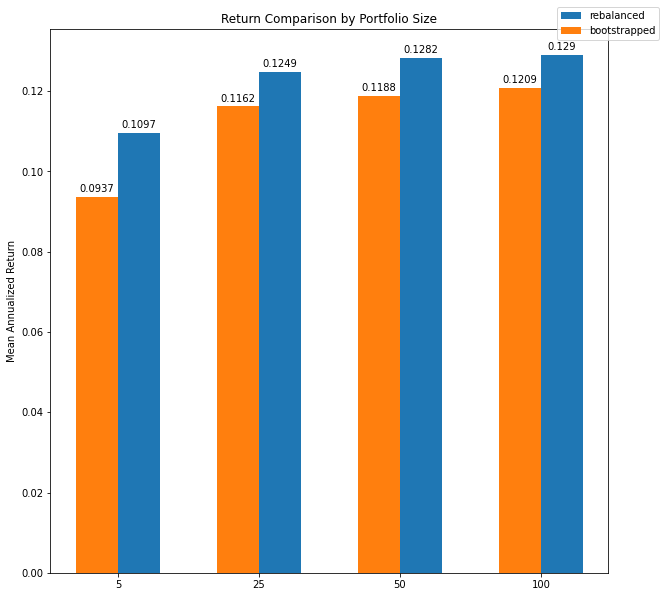

In [37]:
n_list = [5,25,50,100]
labels = [str(x) for x in n_list]
rect_dict = {'bootstrapped':[],'rebalanced':[]}
i = 0
width = 0.3  # the width of the bars
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()

strat_list = ['rebalanced', 'bootstrapped']

for strat in strat_list:
    print(strat)
    mean_list = []
    for size in n_list:
        if i == 0:
            labels.append(size)
        mean_ret = mean(ret_dict[strat][size])
        if strat == 'bootstrapped':
            print(f'Portfolio Size: {size} - Mean Return:{round(mean_ret,4)}, Skew Return:{round(skew(ret_dict[strat][size]),4)},Mean Turnover: N/A')
        else:
            print(f'Portfolio Size: {size} - Mean Return:{round(mean_ret,4)}, Skew Return:{round(skew(ret_dict[strat][size]),4)},Mean Turnover: {round(mean(turnover_dict[strat][size]),4)}')
        mean_list.append(round(mean_ret,4))
    if strat == 'bootstrapped':
        rect_dict[strat] = ax.bar(x = x - width/2,height = mean_list,width = width,label=strat)
    else:
        rect_dict[strat] = ax.bar(x = x + width/2,height = mean_list,width = width,label=strat)
    i += 1
    

ax.set_ylabel('Mean Annualized Return')
ax.set_title('Return Comparison by Portfolio Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.1, 1.05))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for r in rect_dict:
    autolabel(rect_dict[r])

# fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

# Age and Size Through Time

We can see that the rebalanced portfolios are both older, and larger than the bootstrapped portfolios. However due to the 2008 financial crisis we can see that the size of the rebalanced portfolio becomes equal to that of the bootstrapped portfolio. This may suggest that age is the predominant factor


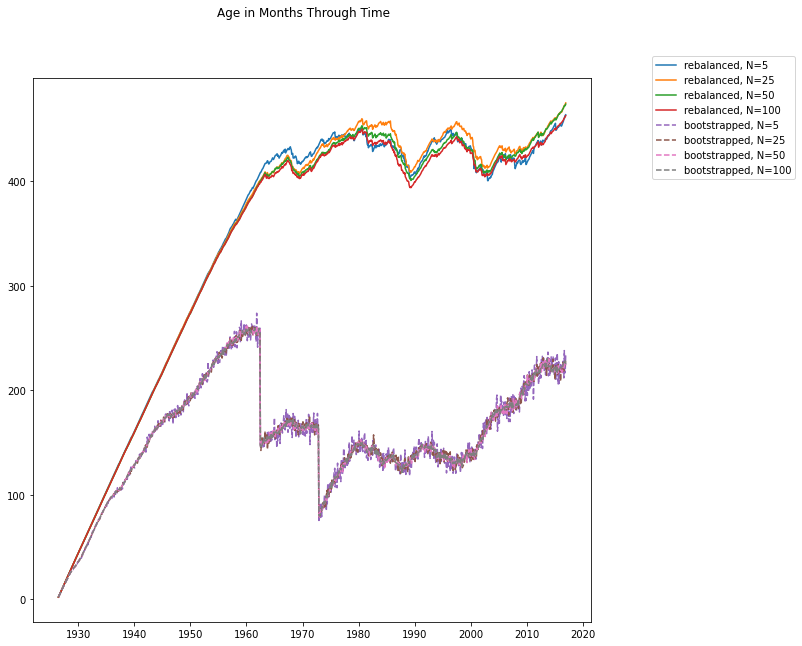

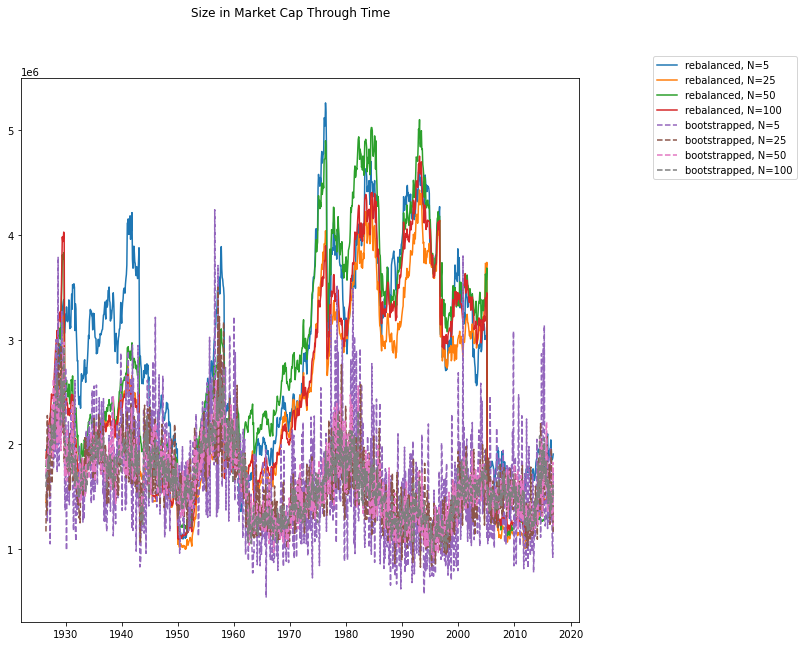

In [52]:
# fig_ret, ax_ret = plt.subplots()
fig_age, ax_age = plt.subplots()
fig_size, ax_size = plt.subplots()
legend_list = []
strat_list = ['rebalanced','bootstrapped']
n_list = [5,25,50,100]
dates = []

for l in listofdates:
    date = datetime.strptime(str(l), '%Y%m').date()
    dates.append(date)


for strat in strat_list:
#     print(strat)
    for N in n_list:
        age_list = []
        size_list = []
        return_list = []
        for i in listofdates:
            age_list.append(mean(age_dict_list[strat][N][i]))
            size_list.append(mean(size_dict_list[strat][N][i]))
        if strat == 'bootstrapped':
            ax_age.plot(dates,age_list, '--')
            ax_size.plot(dates, size_list, '--')
        else:
            ax_age.plot(dates,age_list)
            ax_size.plot(dates, size_list)
        name = f'{strat}, N={N}'
        legend_list.append(name)


ax_age.legend(legend_list, bbox_to_anchor=(1.1, 1.05))
ax_size.legend(legend_list, bbox_to_anchor=(1.4, 1.05))

fig_age.suptitle('Age in Months Through Time')
fig_size.suptitle('Size in Market Cap Through Time')

fig_age.set_figheight(10)
fig_age.set_figwidth(10)

fig_size.set_figheight(10)
fig_size.set_figwidth(10)

plt.show()    

# Turnover Through Time

We can see that in periods of volatility, such as 2008 and the late 1990's turnover spikes. As stocks move around more more wealth from the rebalanced portfolios must be sacrificed.

Text(0.5, 0.98, 'Rebalanced Portfolio Overtime')

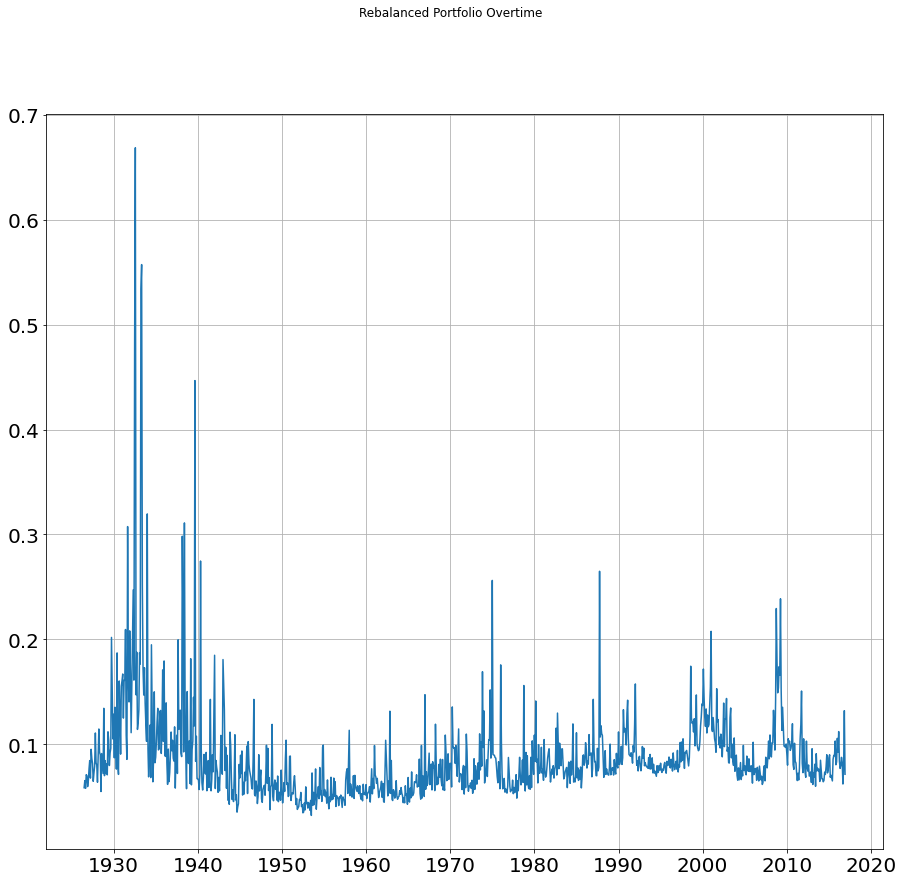

In [49]:
    
import json
from datetime import datetime
import matplotlib.dates as mdates
from statistics import median    
    

avg_dict_ret = {}
avg_dict_turn = {}
for i in listofdates:
    avg_dict_ret[i] = sum(ret_dict_list['rebalanced'][100][i])/len(ret_dict_list['rebalanced'][100][i])
    avg_dict_turn[i] = sum(turnover_dict_list['rebalanced'][100][i])/len(turnover_dict_list['rebalanced'][100][i])

    

dates = list(avg_dict_turn.keys())           # list() needed for python 3.x
for l in range(0,len(dates)):
    date = datetime.strptime(str(dates[l]), '%Y%m').date()
    dates[l] = date
AVG_turnover = list(avg_dict_turn.values())        # ditto
rounded_avg_turnover = [ round(elem, 2) for elem in AVG_turnover]
fig, ax = plt.subplots()

#set locator to every decade
locator = mdates.YearLocator(10)

ax.xaxis.set_major_locator(locator)



ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()


ax.plot_date(dates, AVG_turnover, '-')


fig.set_figheight(15)
fig.set_figwidth(15)

# fig.suptitle('Turnover Through Time', fontsize=20)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

fig.suptitle('Rebalanced Portfolio Overtime')

# fig.savefig('turnover.png')

# Turnover vs annualized return for rebalanced portfolios

There does not appear to be a relationship between increased turnover and increased annualized return.

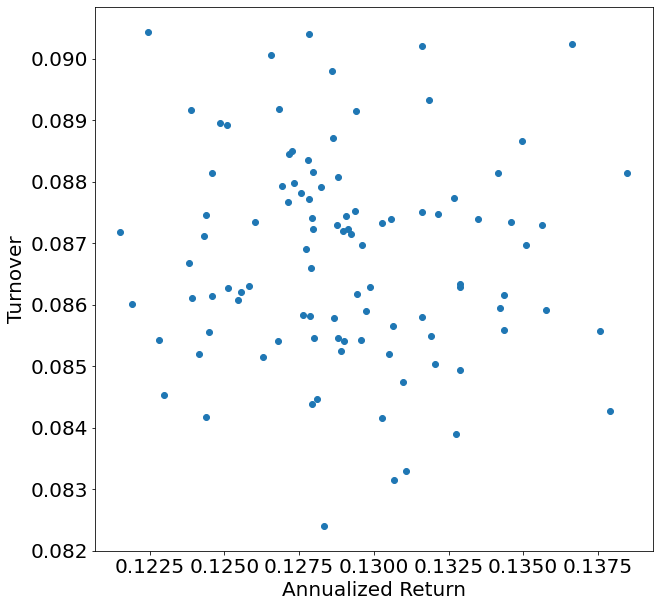

In [47]:
from sklearn.linear_model import LinearRegression

x = np.asarray(ret_dict['rebalanced'][100])
y = np.asarray(turnover_dict['rebalanced'][100])
fig, ax = plt.subplots()
ax.scatter(x,y)

ax.set_xlabel('Annualized Return', fontsize = 20)
ax.set_ylabel('Turnover', fontsize = 20)
fig.set_figheight(10)
fig.set_figwidth(10)

ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

# fig.savefig('scatter.png')

